In [1]:
#vibo: Виталий_Бочаров_56089805 ТЕЛЕГРАММ @vibo22"

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [2]:
#vibo: импортируем бибилотеки base_line
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
#vibo: монтируем google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#vibo: качаем с кагла датасет, выкладываем в папку на google disc, разархивируем

#vibo: но не все так просто, сначала нужно удалить все г из архива и сделать faces_dataset_small.zip
#vibo: в котором структура следующая faces_dataset_small/faces_dataset_small/картинки
#vibo: иначе даталоадер стандартный не грузил

!unzip '/content/drive/MyDrive/Colab Notebooks/faces_dataset_small.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/faces_dataset_small.zip
   creating: faces_dataset_small/
   creating: faces_dataset_small/faces_dataset_small/
  inflating: faces_dataset_small/faces_dataset_small/04181.png  
  inflating: faces_dataset_small/faces_dataset_small/00481.png  
  inflating: faces_dataset_small/faces_dataset_small/04195.png  
  inflating: faces_dataset_small/faces_dataset_small/01984.png  
  inflating: faces_dataset_small/faces_dataset_small/02255.png  
  inflating: faces_dataset_small/faces_dataset_small/04624.png  
  inflating: faces_dataset_small/faces_dataset_small/02241.png  
  inflating: faces_dataset_small/faces_dataset_small/04630.png  
  inflating: faces_dataset_small/faces_dataset_small/01990.png  
  inflating: faces_dataset_small/faces_dataset_small/04618.png  
  inflating: faces_dataset_small/faces_dataset_small/00873.png  
  inflating: faces_dataset_small/faces_dataset_small/02731.png  
  inflating: faces_dataset_small/faces_dataset_small/03413.

In [5]:
#vibo: устанавливаем рабочую дирректорию
DATA_DIR = './faces_dataset_small/'

In [6]:
#vibo: проверим рабочую дирректорию
!ls ./faces_dataset_small

faces_dataset_small


In [7]:
#vibo: количество файлов в датасете
import os.path
path = './faces_dataset_small/faces_dataset_small/'
num_files = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
num_files

3144

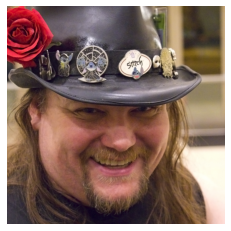

In [39]:
#vibo: произвольная картинка
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = './faces_dataset_small/faces_dataset_small/00772.png'
image = mpimg.imread(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()
#vibo: изображения большие 1024х1024, их предлагают ресайзнуть к 128х128 либо немного больше

In [ ]:
# def get_dataloader(image_size, batch_size):
#   """
#   Builds dataloader for training data.
#   Use tt.Compose and tt.Resize for transformations
#   :param image_size: height and wdith of the image
#   :param batch_size: batch_size of the dataloader
#   :returns: DataLoader object 
#   """
#   # TODO: resize images, convert them to tensors and build dataloader
#   pass

In [9]:
#vibo: задание 1 написать функцию get_dataloader
def get_dataloader(image_size, batch_size):
  #vibo: обработаем исходные изображения, применим композицию преобразований Compose
  train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
      #vibo: делаем размер 64*64 (image_size = 64 выше)
      tt.Resize(image_size),
      #vibo: обрезаем изображение по центру
      tt.CenterCrop(image_size),
      #vibo: преобразуем к тензору
      tt.ToTensor(),
      #vibo: нормализуем изображение (stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      tt.Normalize(*stats)]))
  #vibo: загружаем все в даталоадер
  #vibo: num_workers - многопроцессорная загрузка данных с указанным количеством рабочих процессов загрузчика
  #vibo: pin_memory=True обеспечивает более быструю передачу данных на GPU
  train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  return train_dl

In [10]:
#vibo: выставляем параметры
#vibo: размер картинок
image_size = 128
#vibo: батч
batch_size = 64
#vibo: параметры нормализации из семинара
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

#TODO: build dataloader and transfer it to device

In [11]:
#vibo: base_line для отрисовки картинок
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

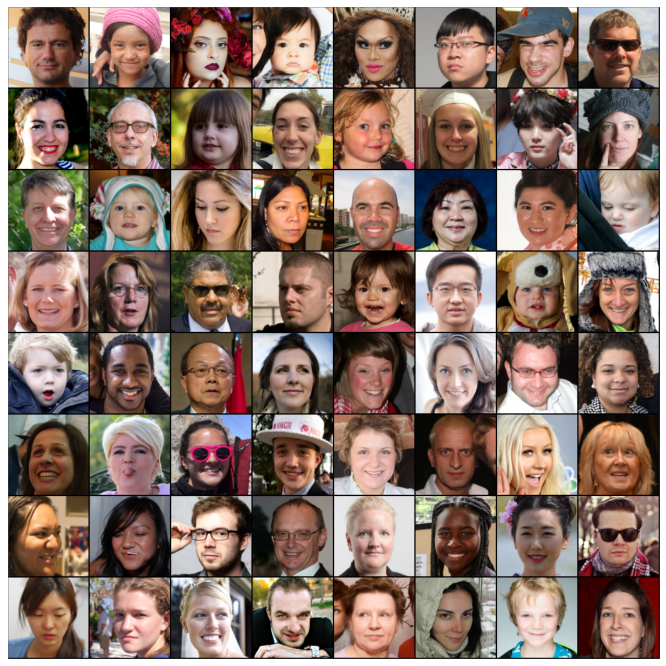

In [12]:
#vibo: готовый даталоадер
train_dl = get_dataloader(image_size=image_size, batch_size=batch_size)
show_batch(train_dl)

In [13]:
#vibo: base_line из семинара
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [14]:
#vibo: проверим даталоадер
for i in train_dl:
  print(i[0].shape)
  break
#vibo: на выходе батч - 64, 3 - канала rgb, размер 128х128

torch.Size([64, 3, 128, 128])


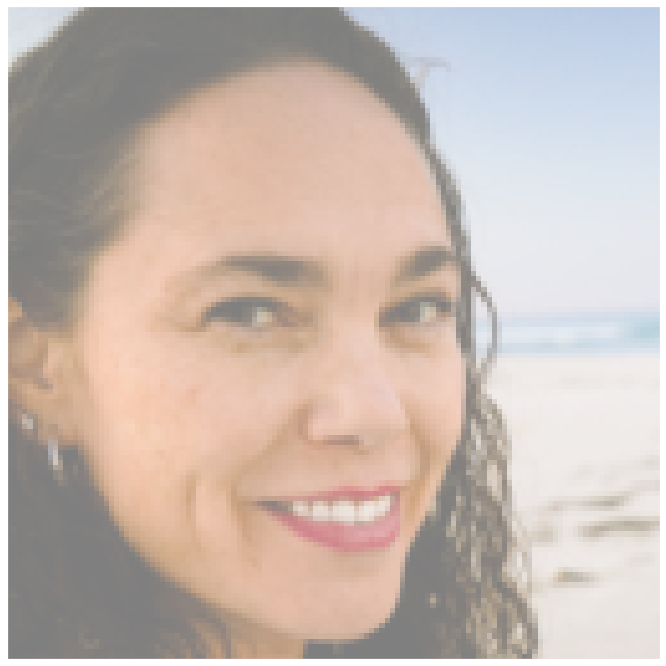

In [15]:
#vibo: проверил как в обратную сторону работают ф-ции base-line семинара
for i in train_dl:
  show_images(denorm(i[0:64][0][0]))
  break
#vibo: все какое-то блеклое

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [16]:
#vibo: дискриминатор base_line - принимает на вход картинку
discriminator = nn.Sequential(
    #vibo: здесь тензор 3 x 128 x 128
    nn.Conv2d(3, image_size, kernel_size=16, stride=8, padding=4, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #vibo: здесь тензор 128 x 16 x 16
    nn.Conv2d(128, 512, kernel_size=8, stride=4, padding=2, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #vibo: здесь тензор 512 x 4 x 4
    nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2, inplace=True),
    #vibo: здесь тензор 1024 x 2 x 2   
    nn.Conv2d(1024, 1, kernel_size=2, stride=1, padding=0, bias=False),
    #vibo: здесь тензор 1 x 1 x 1
    #vibo: для получения вероятности принадлежности к классу 1 применяем Flatten + Sigmoid 
    nn.Flatten(),
    nn.Sigmoid()
)
#vibo: на выходе дискриминатора вероятность того, что картинка настоящая

In [17]:
#vibo: проверяем работоспособность дискриминатора 
from torchsummary import summary
summary(discriminator.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 16, 16]          98,304
       BatchNorm2d-2          [-1, 128, 16, 16]             256
         LeakyReLU-3          [-1, 128, 16, 16]               0
            Conv2d-4            [-1, 512, 4, 4]       4,194,304
       BatchNorm2d-5            [-1, 512, 4, 4]           1,024
         LeakyReLU-6            [-1, 512, 4, 4]               0
            Conv2d-7           [-1, 1024, 2, 2]       8,388,608
       BatchNorm2d-8           [-1, 1024, 2, 2]           2,048
         LeakyReLU-9           [-1, 1024, 2, 2]               0
           Conv2d-10              [-1, 1, 1, 1]           4,096
          Flatten-11                    [-1, 1]               0
          Sigmoid-12                    [-1, 1]               0
Total params: 12,688,640
Trainable params: 12,688,640
Non-trainable params: 0
-------------------------

In [18]:
#vibo: постороенный дискриминатор, обзор ниже
discriminator.parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 128, kernel_size=(16, 16), stride=(8, 8), padding=(4, 4), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(128, 512, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2), bias=False)
  (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(1024, 1, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Sigmoid()
)>

In [19]:
#vibo: далее все как на семинаре
discriminator = to_device(discriminator, device)
#vibo: размер латентного вектора
latent_size = 128 # choose latent size

In [20]:
#vibo: теперь делаем генератор, хотим сделать изображение похожее на те, что есть в датасете
generator = nn.Sequential(
    #vibo: на входе вектор шума, размера latent_size, выше выбран равным 128
    #vibo: здесь тензор  latent_size (128) x 1 x 1
    nn.ConvTranspose2d(latent_size, 2048, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(2048),
    nn.ReLU(True),
    #vibo: здесь тензор 2048 x 2 x 2
    nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    #vibo: здесь тензор 1024 x 4 x 4
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    #vibo: здесь тензор 512 x 8 x 8
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #vibo: здесь тензор 256 x 16 x 16
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #vibo: здесь тензор 128 x 32 x 32
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #vibo: здесь тензор 64 x 64 x 64
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    #vibo: здесь тензор 3 x 128 x 128
    #vibo: гиперболический тангенс для того, чтобы все было норм с цветами изображений
    #vibo: все изображения приводим к даипазону от -1 до 1
    nn.Tanh()
    #vibo: здесь тензор 3 x 128 x 128
)

In [21]:
generator = to_device(generator, device)

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
#vibo: batch_size=64
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

In [24]:
fixed_latent.shape

torch.Size([64, 128, 1, 1])

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
#vibo: проверяем работоспособность дискриминатора 
from torchsummary import summary
summary(generator.to(device), input_size=(128, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1           [-1, 2048, 2, 2]       4,194,304
       BatchNorm2d-2           [-1, 2048, 2, 2]           4,096
              ReLU-3           [-1, 2048, 2, 2]               0
   ConvTranspose2d-4           [-1, 1024, 4, 4]      33,554,432
       BatchNorm2d-5           [-1, 1024, 4, 4]           2,048
              ReLU-6           [-1, 1024, 4, 4]               0
   ConvTranspose2d-7            [-1, 512, 8, 8]       8,388,608
       BatchNorm2d-8            [-1, 512, 8, 8]           1,024
              ReLU-9            [-1, 512, 8, 8]               0
  ConvTranspose2d-10          [-1, 256, 16, 16]       2,097,152
      BatchNorm2d-11          [-1, 256, 16, 16]             512
             ReLU-12          [-1, 256, 16, 16]               0
  ConvTranspose2d-13          [-1, 128, 32, 32]         524,288
      BatchNorm2d-14          [-1, 128,

In [27]:
#vibo: постороенный генератор, обзор ниже
generator.parameters

<bound method Module.parameters of Sequential(
  (0): ConvTranspose2d(128, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): 

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [40]:
#vibo: base-line, исправил только nn.BCELoss() у generator
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

#vibo: количество эпох
epochs = 40

In [41]:
#vibo: base-line
def fit(model, criterion, epochs, lr, start_idx=1):
    # TODO: build optimizers and train your GAN
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            
            #vibo: изображения на cuda
            real_images = real_images.to(device)

            #vibo: важно! учим генератор и дискриминатор поочереди, отдельно
            #vibo: первый шаг - обучение дискриминатора

            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            #vibo: берем реальные изображения из train
            real_preds = model["discriminator"](real_images)
            #vibo: присваиваем этим изображениям метку 1 класс
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            #vibo: учим дискриминатор предсказывать эту метку класса,
            #vbio: в качестве функции потерь берем бинарную кросс-энтропию nn.BCELoss() (см. ниже)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            #vibo: после того, как подали в дикриминатор настоящие изображения, подаем fake

            # Generate fake images
            #vibo: генерируем случайный вектор
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            #vibo: пропускаем случайный вектор через генератор
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            #vibo: присваиваем получившимся изображениям метку класса 0
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            #vibo: подаем в дикриминатор, считаем бинарую кросс-энтропию
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            #vibo: считаем score по всем предсказаниям
            cur_fake_score = torch.mean(fake_preds).item()

            #vibo: для реальных картинок ожидаем близкое к 1
            real_score_per_epoch.append(cur_real_score)
            #vibo: для сгенерированных картинок близкое к 0
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            #vibo: складываем loss, который получился когда подавали реальное и fake изображение
            loss_d = real_loss + fake_loss
            #vibo: делаем backward-pass
            #vibo: на этом обучение дискриминатора закончено, генератор на этом этапе веса никак не обновляет
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())

            #vibo: обучение ГЕНЕРАТОРА
            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            #vibo: генерируем fake изображение
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            #vibo: подаем на вход дисриминатору
            preds = model["discriminator"](fake_images)
            #vibo: в качестве меток снова берем 1
            targets = torch.ones(batch_size, 1, device=device)
            #vibo: считаем loss уже ГЕНЕРАТОРА
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            #vibo: обновляем веса генератора
            loss_g.backward()
            #vibo: делаем шаг оптимайзера (они разные для генератора и дикриминатора)
            optimizer["generator"].step()
            #vibo: сохраним loss
            loss_g_per_epoch.append(loss_g.item())
            
        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
        # Save generated images
        if epoch == epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [42]:
#vibo: обучаем модель на 20 эпох, для количества картинок 3144, батч по 64 картинки, поулчаем 50 батчей
history = fit(model, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/40], loss_g: 5.1296, loss_d: 0.9528, real_score: 0.8056, fake_score: 0.3327


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/40], loss_g: 2.0915, loss_d: 1.3423, real_score: 0.5380, fake_score: 0.4620


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/40], loss_g: 1.5131, loss_d: 1.2297, real_score: 0.5548, fake_score: 0.4318


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/40], loss_g: 1.6980, loss_d: 1.2104, real_score: 0.5670, fake_score: 0.4169


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/40], loss_g: 1.8739, loss_d: 1.1488, real_score: 0.5880, fake_score: 0.4060


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/40], loss_g: 2.0997, loss_d: 1.1701, real_score: 0.5823, fake_score: 0.4095


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/40], loss_g: 2.0710, loss_d: 1.1259, real_score: 0.5966, fake_score: 0.3988


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/40], loss_g: 2.2594, loss_d: 1.1634, real_score: 0.6127, fake_score: 0.4015


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/40], loss_g: 2.1457, loss_d: 1.1029, real_score: 0.6152, fake_score: 0.3835


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/40], loss_g: 2.1245, loss_d: 1.0507, real_score: 0.6231, fake_score: 0.3723


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/40], loss_g: 2.1826, loss_d: 1.1760, real_score: 0.5970, fake_score: 0.4064


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/40], loss_g: 2.1920, loss_d: 1.1524, real_score: 0.6065, fake_score: 0.4031


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/40], loss_g: 2.5579, loss_d: 1.0968, real_score: 0.6190, fake_score: 0.3702


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/40], loss_g: 2.3252, loss_d: 1.0345, real_score: 0.6320, fake_score: 0.3677


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/40], loss_g: 2.7049, loss_d: 1.0481, real_score: 0.6353, fake_score: 0.3658


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/40], loss_g: 2.5047, loss_d: 1.1271, real_score: 0.6163, fake_score: 0.3854


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/40], loss_g: 2.6112, loss_d: 1.0096, real_score: 0.6454, fake_score: 0.3522


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/40], loss_g: 2.6509, loss_d: 1.0416, real_score: 0.6339, fake_score: 0.3599


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/40], loss_g: 2.4368, loss_d: 1.0165, real_score: 0.6396, fake_score: 0.3589


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/40], loss_g: 2.5031, loss_d: 1.0964, real_score: 0.6186, fake_score: 0.3727


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/40], loss_g: 2.5070, loss_d: 1.0425, real_score: 0.6367, fake_score: 0.3664


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/40], loss_g: 2.4327, loss_d: 1.0596, real_score: 0.6247, fake_score: 0.3688


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/40], loss_g: 2.3830, loss_d: 1.0879, real_score: 0.6151, fake_score: 0.3825


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/40], loss_g: 2.3374, loss_d: 1.0286, real_score: 0.6326, fake_score: 0.3631


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/40], loss_g: 2.3258, loss_d: 1.0593, real_score: 0.6233, fake_score: 0.3646


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/40], loss_g: 2.2142, loss_d: 1.0944, real_score: 0.6256, fake_score: 0.3870


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/40], loss_g: 2.2631, loss_d: 1.1172, real_score: 0.6062, fake_score: 0.3832


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/40], loss_g: 2.0506, loss_d: 1.1436, real_score: 0.5973, fake_score: 0.3972


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/40], loss_g: 2.0550, loss_d: 1.0578, real_score: 0.6159, fake_score: 0.3746


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/40], loss_g: 2.1811, loss_d: 1.0596, real_score: 0.6232, fake_score: 0.3749


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/40], loss_g: 2.2928, loss_d: 1.0012, real_score: 0.6378, fake_score: 0.3614


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/40], loss_g: 2.2777, loss_d: 1.0346, real_score: 0.6258, fake_score: 0.3668


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/40], loss_g: 2.4632, loss_d: 0.9868, real_score: 0.6435, fake_score: 0.3530


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/40], loss_g: 2.3409, loss_d: 1.0264, real_score: 0.6333, fake_score: 0.3605


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/40], loss_g: 2.3996, loss_d: 0.9658, real_score: 0.6537, fake_score: 0.3505


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/40], loss_g: 2.5350, loss_d: 0.9928, real_score: 0.6402, fake_score: 0.3479


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/40], loss_g: 2.4023, loss_d: 0.9549, real_score: 0.6545, fake_score: 0.3436


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/40], loss_g: 2.3745, loss_d: 0.9607, real_score: 0.6501, fake_score: 0.3486


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/40], loss_g: 2.5248, loss_d: 0.9679, real_score: 0.6546, fake_score: 0.3482


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/40], loss_g: 2.3064, loss_d: 1.0492, real_score: 0.6252, fake_score: 0.3576
Saving generated-images-0040.png


In [43]:
losses_g, losses_d, real_scores, fake_scores = history

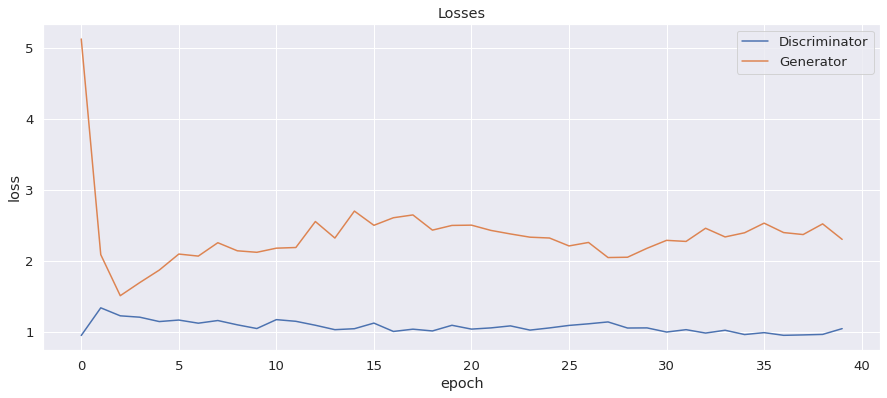

In [44]:
#vibo: строим графики функции потерь дискриминатора и генератора
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [45]:
#vibo: loss генератора сначала снижается, потом начинает повышаться, loss дискриминатора сначала повышается, заметм понижается

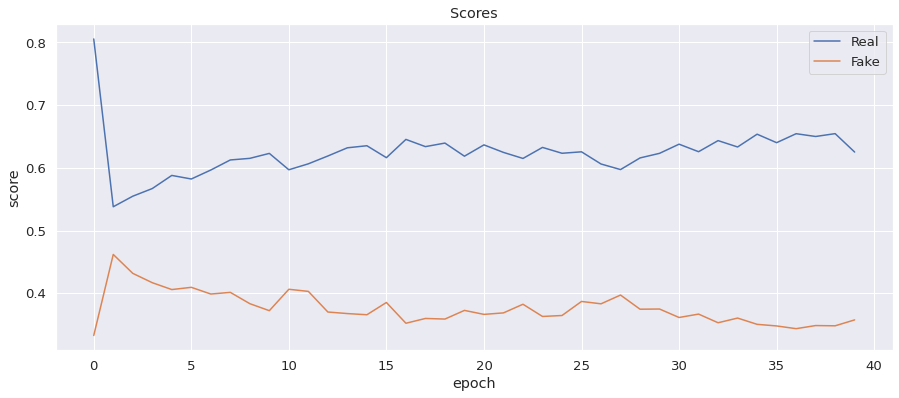

In [46]:
#vibo: строим графики score для настоящих и сгенерированных изображений
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [62]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [48]:
# def show_images(generated):
#   # TODO: show generated images
#   pass

In [54]:
def show_images(generated, nmax=64):
    # TODO: show generated images
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated.detach()[:nmax]), nrow=8).permute(1, 2, 0))

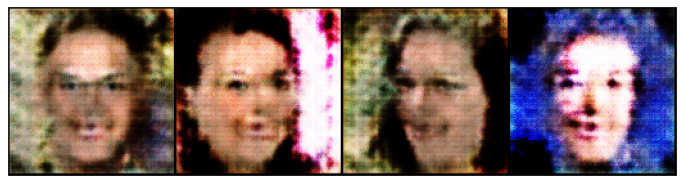

In [63]:
show_images(fake_images.cpu())

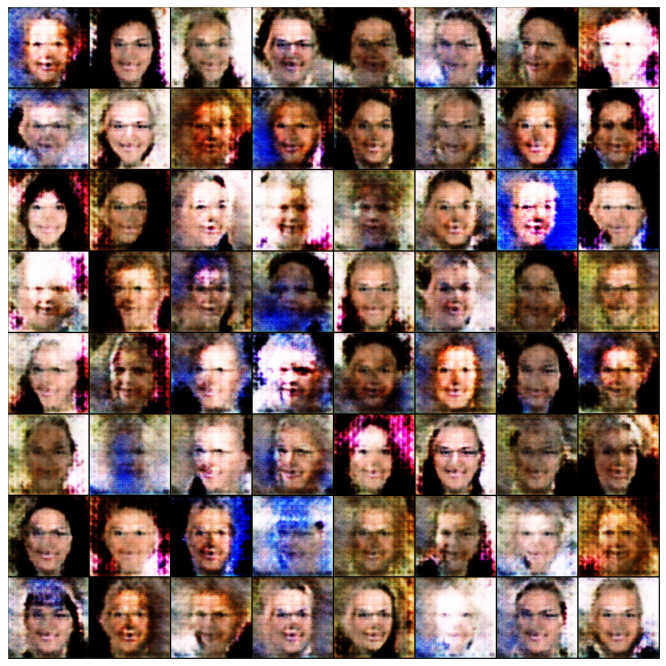

In [64]:
n_images = 64

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)
show_images(fake_images.cpu())

Как вам качество получившихся изображений?

In [65]:
#vibo: могло быть и хуже ;)

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: